In [1]:
from src.lindbladAG import lindbladianAG, mesolveAG
import numpy as np
from qutip import Qobj, basis, brmesolve
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Comparison with qutip's brmesolve (no cross-correlations and no Lamb-shift)

In [2]:
# size of system

nLevels = 2
nOperators = 1
nModes = 1

In [3]:
# Parameters

np.random.seed(123456789)
# Hamiltonian (hermitian but not diagonal)
H = Qobj((h:=np.random.rand(nLevels, nLevels)) + h.T)
evals = H.eigenenergies()
H = Qobj(np.diag(evals))

# Operators mediating system-bath interactions
a_ops = []
for i in range(nOperators):
    op = np.random.rand(nLevels, nLevels)
    op += op.T
    op -= np.diag(np.diagonal(op))
    a_ops.append(Qobj(op))

In [24]:
# Bath spectral functions

# mode energies (ordered for clarity)
energies = np.random.rand(nModes) * (max(evals) - min(evals)) + max(min(evals), 0.0)
np.ndarray.sort(energies)

# mode couplings
couplings = np.random.rand(nModes, nModes) * 0.5
for i in range(nModes): couplings[i, i] = 0
couplings = (couplings + couplings.T) * 0.5

# decay rate of each mode
κi = np.random.rand(nModes) * (0.5 - 0.2) + 0.6

# matrix 
h = np.diag(energies) + couplings - 0.5j * np.diag(κi)

# mode "field strengths" as felt by each emitter operator
g = np.random.rand(nOperators, nModes) * np.sqrt(0.1)

# spectral density
frequency = np.linspace(-10, 10, 500)
J_arr = 1 / np.pi * g @ np.linalg.inv(h - frequency[:, np.newaxis, np.newaxis] * np.identity(nModes)).imag @ g.T
J = np.empty(nOperators, dtype=object)
for i in range(nOperators):
    J[i] = interp1d(frequency, J_arr[:, i, i], bounds_error=False, fill_value=0) 

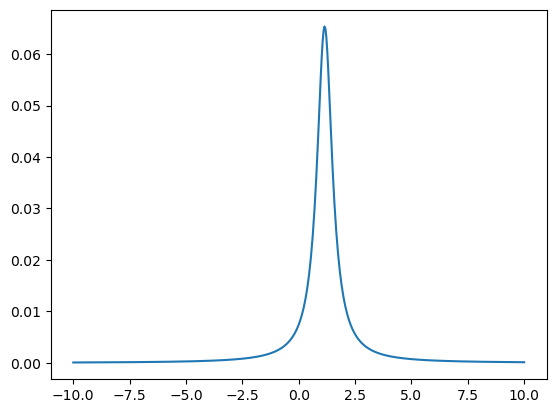

In [25]:
for j in J:
    plt.plot(frequency, j(frequency))

In [26]:
# Time evolution:

# initial state
psi0 = 0
for i in range(nLevels):
    psi0 += np.random.rand() * basis(nLevels, i)
psi0 = psi0.unit()

# time array
t = np.linspace(0, 1000, 500)

# expectation operators (populations)
e_ops = [basis(nLevels, i) * basis(nLevels, i).dag() for i in range(nLevels)]

# 1. Bloch-Redfield
rhoBR = brmesolve(H=H, psi0=psi0, tlist=t, a_ops=[[np.sqrt(2*np.pi)*a, j] for a, j in zip(a_ops, J)], e_ops=e_ops).expect

# 2. Arithmetic-Geometric master equation
rhoAG = mesolveAG(H=H, psi0=psi0, tlist=t, a_ops=a_ops, J=J, e_ops=e_ops).expect


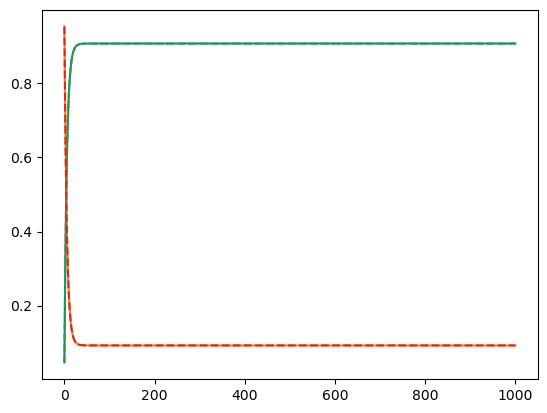

In [27]:
for p in rhoBR:
    plt.plot(t, p)
for p in rhoAG:
    plt.plot(t, p.real, "--")

In [28]:
a_ops

[Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[0.         1.63657279]
  [1.63657279 0.        ]]]